###### 參考資料
1. [[實戰系列] 使用 Keras 搭建一個 GAN 魔法陣（模型）](https://ithelp.ithome.com.tw/articles/10208478)
2. [[魔法陣系列] Generative Adversarial Network（GAN）之術式解析](https://ithelp.ithome.com.tw/articles/10207229)
3. [[魔法陣系列] AutoEncoder 之術式解析](https://ithelp.ithome.com.tw/articles/10206869)
4. [[魔法陣系列] AutoEncoder 之應用場景](https://ithelp.ithome.com.tw/articles/10207903)
5. [龔給的，AAE懶人包](https://github.com/eriklindernoren/Keras-GAN/tree/master/aae)

###### 紀錄
1. !cd 失敗，若需要可以考慮 os.chdir("/content/drive/")

###### 規則補充
- 52張拿出以下8張當test imags, 其餘為training images: 
- 紅桃 6, J; 黑桃 7, Q; 鑽石 8, K; 梅花 9, Q
 - => 32、37、46、50、21、26、9、12
- input 採PCA 60% 結果; 
- 要寫Autoencoder 和Autoencoder+Gan 兩種程式, 比較結果.

In [0]:
import os, time
from cv2 import imwrite

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
DEBUG_PRINT = True

### 檔案連結

In [0]:
from google.colab import drive

In [39]:
# 連接雲端
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [40]:
!ls /content/gdrive/"My Drive"/"Colab Notebooks"/0104_AE-GAN/

0114_00_makeDataNPY.ipynb  org.npy		   poker_data_org
0114_AE.ipynb		   output0115_AE	   poker_data_PCA60
0114_GAN.ipynb		   output0115_AE-GAN	   poker_data_PCA80
AE-GAN.log		   output0115_AE-GAN_1030
AE.log			   pca60.npy


In [0]:
mainFolder = "/content/gdrive/My Drive/Colab Notebooks/0104_AE-GAN/"

In [42]:
os.listdir(mainFolder)

['poker_data_PCA60',
 'poker_data_org',
 'poker_data_PCA80',
 'org.npy',
 'pca60.npy',
 '0114_00_makeDataNPY.ipynb',
 'output0115_AE',
 'output0115_AE-GAN_1030',
 'output0115_AE-GAN',
 'AE-GAN.log',
 'AE.log',
 '0114_AE.ipynb',
 '0114_GAN.ipynb']

### LOG

In [0]:
def CheckFolder(outputFolder):
    print(outputFolder, ":", end = "")
    if ( os.path.isdir(outputFolder)):
        print("Directory exists~")
        return True
    else:
        print("Directory not found!")
        os.mkdir(outputFolder)
        if ( os.path.isdir(outputFolder)):
            print("CREAT DONE: Directory exists!")
            return True
    return False

In [0]:
from pytz import timezone
from datetime import datetime
class DataLog:
    def __init__(self, timezone_local = "Asia/Taipei" ):
        # 
        self.SetFolder("./", txtName = "tmp")
        print("Remember Set Folder")
        # timeaone set #TPE 以這樣的變數可能要改一下變數名稱
        self.tpe = timezone(timezone_local)
        return
    def SetFolder(self, folder, txtName = None, file_extension = ".txt"):
        if folder[-1] != "/":
            folder += "/"
        CheckFolder(folder)
        # name set
        self.folder = folder
        if txtName is None:
            self.txtName = folder.rsplit("/", 2)[1] + file_extension
        elif txtName.rsplit(".", 1)[-1] != file_extension:
            self.txtName = txtName + file_extension
        else:
            self.txtName = txtName
        return
    def GetTime_TPE(self):
        utcnow = datetime.utcnow()
        return self.tpe.fromutc(utcnow).timetuple()
    def WriteLog(self, inputString):
        with open(self.folder + self.txtName, "a") as f:
            f.write(inputString + "\n")
        return inputString
    def SetTimeLog(self, eventTitle):
        time_now = self.GetTime_TPE()
#         self.WriteLog(eventTitle + ": " + "-".join([str(i) for i in time_now[0:3]]) + " " +":".join([str(i) for i in time_now[3:5]]))
        self.WriteLog("%s : %4d-%2d-%2d %2d:%2d"%(eventTitle, time_now[0], time_now[1], time_now[2], time_now[3], time_now[4]))
        return

In [45]:
OWNLog = DataLog()

./ :Directory exists~
Remember Set Folder


In [0]:
time_now = OWNLog.GetTime_TPE()

In [47]:
OWNLog.SetFolder(mainFolder, txtName = "AE-GAN", file_extension = ".log")

/content/gdrive/My Drive/Colab Notebooks/0104_AE-GAN/ :Directory exists~


In [0]:
OWNLog.SetTimeLog("START_ALL=1 batch Train 1 Generator==")

### Reslult Function

In [0]:
def ResultImgShow(inputImg1, inputImg2 = None, modelName = "MODELNAME", strImgLabel = "TMP", boolShow = True):
    # 輸出參數設置
    img_amount1 = len(inputImg1)
    if not inputImg2 is None:
        img_amount2 = len(inputImg2)
    cols_output = 4
    rows_output1 = img_amount1//cols_output; #print(rows_output1);
    if not inputImg2 is None:
        rows_output2 = img_amount2//cols_output; #print(rows_output2);
#     if rows_output > cols_output:
#         rows_output = cols_output
    # 輸出設置 - 水平堆疊再垂直堆疊
    ## v - 初始
    img_h = inputImg1[0]
    for i in range(1, cols_output):
        img_tmp = inputImg1[i]
        img_h = np.hstack((img_h, img_tmp))
    img_v = img_h.copy()
    ## v - Loop - inputImg1
    for j in range(1, rows_output1): #在 2
        ## h - 初始
        img_h = inputImg1[j * cols_output]
        ## h - Loop
        for i in range(1, cols_output):
            img_tmp = inputImg1[j * cols_output + i]
            img_h = np.hstack((img_h, img_tmp))
        img_v = np.vstack((img_v, img_h))
    
    if not inputImg2 is None:
        ## v - Loop - inputImg2
        for j in range(0, rows_output2):
            ## h - 初始
            img_h = inputImg2[j * cols_output]
            ## h - Loop
            for i in range(1, cols_output):
                img_tmp = inputImg2[j * cols_output + i]
                img_h = np.hstack((img_h, img_tmp))
            img_v = np.vstack((img_v, img_h))
    
    # 顯示 與 存取
    imwrite(modelName.rsplit(".", 1)[0] +"_"+ strImgLabel+ ".png", img_v)
    if boolShow:
        plt.imshow(img_v, cmap = "gray")
    #     plt.savefig(model_name.split(".")[0] +"_"+ strImgLabel+ ".png")
        plt.show()
        plt.close()
    return

In [0]:
from skimage.measure import compare_psnr, compare_ssim 

In [0]:
def PSNR_ALL(testData, truthData, strImgLabel = "TMP", boolTest = False):
    """ """
#     dataAmount = 1 if testData.shape < 3 else testData.shape[0]
#     if testData.shape < 3:
#         dataAmount = 1
#     else:
    dataAmount = testData.shape[0]
    psnrSum_test = 0
    for i in range(dataAmount):
        groundTruth   = truthData[i, :,:]
        predictResult = testData[i, :,:]
        psnrTmp = float(compare_psnr(groundTruth, predictResult))
        psnrSum_test += psnrTmp
    psnrSum_test /= dataAmount
    print(strImgLabel, "PSNR:", psnrSum_test)
    return psnrSum_test

In [0]:
def SSIM_ALL(testData, truthData, strImgLabel = "TMP", boolTest = False):
    dataAmount = testData.shape[0]
    ssimSum_test = 0
    for i in range(dataAmount):
        groundTruth   = truthData[i, :,:]
        predictResult = testData[i, :,:]
        ssimTmp = float(compare_ssim(groundTruth, predictResult))
        ssimSum_test += ssimTmp
    ssimSum_test /= dataAmount
    print(strImgLabel, "SSIM:", ssimSum_test)
    return ssimSum_test

In [0]:
# def DataPreProcess(inputData, img_rows = 28, img_cols = 28):
#     outputData = inputData.reshape(inputData.shape[0], img_rows * img_cols)
#     outputData = outputData.astype('float32') /255 -0.5
#     outputData *= 2
#     return outputData
# def DataRecovery(inputData, img_rows = 28, img_cols = 28):
#     outputData = ((inputData /2)+0.5) * 255
#     outputData = outputData.reshape((outputData.shape[0], img_rows, img_cols))
#     outputData = outputData.astype('uint8')
#     return outputData

# 主程式

## 匯入

In [0]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, merge
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K

## 參數

In [0]:
OWNLog.SetTimeLog("START_MAIN")

In [56]:
outputFolder = mainFolder + "output0115_AE-GAN/"
CheckFolder(outputFolder);
batch_size = 13 
# num_classes = 10
epochs = 4000
# input image dimensions
img_rows, img_cols = 96, 71

/content/gdrive/My Drive/Colab Notebooks/0104_AE-GAN/output0115_AE-GAN/ :Directory exists~


## CLASS

In [0]:
class AdversarialAutoencoder():
    def __init__(self):
        self.img_rows = 96
        self.img_cols = 71
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 50
        
        self.train_data_amount = 52 - 8

        optimizer_d = Adam(0.0001)
        optimizer_g = Adam(0.0001)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer_d,
                                   metrics=['accuracy'])

        # Build the encoder / decoder
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

        img = Input(shape=self.img_shape)
        # The generator takes the image, encodes it and reconstructs it
        # from the encoding
        encoded_repr      = self.encoder(img)
        reconstructed_img = self.decoder(encoded_repr)

        # For the adversarial_autoencoder model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator determines validity of the encoding
        validity = self.discriminator(reconstructed_img)

        # The adversarial_autoencoder model  (stacked generator and discriminator)
        self.adversarial_autoencoder = Model(img, [reconstructed_img, validity])
        self.adversarial_autoencoder.compile(loss=['mse', 'binary_crossentropy'],
            loss_weights=[0.999, 0.001],
            optimizer=optimizer_g)
        
        print("self.adversarial_autoencoder")
        self.adversarial_autoencoder.summary()


    def build_encoder(self):
        # Encoder

        img = Input(shape=self.img_shape)

        h = Flatten()(img)
        encoded = Dense(1500, activation='relu')(h)
        encoded = Dense(375, activation='relu')(encoded)
        latent_repr = Dense(self.latent_dim)(encoded)

        return Model(img, latent_repr)

    def build_decoder(self):

        model = Sequential()

        model.add(Dense(375, activation='relu' , input_dim=self.latent_dim))
        model.add(Dense(1500, activation='relu')) 
        model.add(Dense(np.prod(self.img_shape), activation='tanh')) 
        model.add(Reshape(self.img_shape))
        print("build_decoder")
        model.summary()

        z = Input(shape=(self.latent_dim,))
        img = model(z)

        return Model(z, img)

    def build_discriminator(self):

        model = Sequential()
        
        model.add(Flatten(input_shape = self.img_shape))
        model.add(Dense(64, activation = "relu"))
        model.add(Dense(32, activation = "relu"))
        model.add(Dense(1, activation = "sigmoid"))
        print("build_discriminator")
        model.summary()

        img = Input(shape=(self.img_shape))
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs=100, batch_size=13, sample_interval=50):
        global mainFolder
        datasetFolder = mainFolder
        # Load the dataset
        dataSetName_org   = "org.npy"
        dataSetName_noise = "pca60.npy"
#         (X_train, _), (_, _) = mnist.load_data()
        f = np.load(datasetFolder + dataSetName_org).item()
        x_train_org, x_test_org     = np.array(f['train']), np.array(f['test'])
        f = np.load(datasetFolder + dataSetName_noise).item()
        x_train_noise, x_test_noise = np.array(f['train']), np.array(f['test'])
        del f
        
#         # Rescale -1 to 1
#         X_train = (X_train.astype(np.float32) - 127.5) / 127.5
#         X_train = np.expand_dims(X_train, axis=3)
        # Rescale
        x_train_noise = self.DataPreProcess(x_train_noise)
        x_train_org   = self.DataPreProcess(x_train_org)
        x_test_noise  = self.DataPreProcess(x_test_noise)

        for epoch in range(epochs):
            _epoch_start_time = time.time()
                
            # ---------------------
            #  Train Discriminator
            # ---------------------
            
            idxTrain = np.arange(x_train_noise.shape[0])
            np.random.shuffle(idxTrain)

            boolBatchDone = False
            batchCount = 0
            while (not boolBatchDone):
                # Select a random batch of images
                if batchCount + batch_size < self.train_data_amount:
                    img_o = x_train_org[  idxTrain[batchCount:batchCount + batch_size]]
                    img_n = x_train_noise[idxTrain[batchCount:batchCount + batch_size]]
#                     # Adversarial ground truths
#                     valid = np.ones((batch_size, 1))
#                     fake = np.zeros((batch_size, 1))
                    batchCount += batch_size
                else:
                    boolBatchDone = True
                    img_o = x_train_org[  idxTrain[batchCount:]]
                    img_n = x_train_noise[idxTrain[batchCount:]]
                
                # Adversarial ground truths
                valid = np.ones((img_o.shape[0], 1))
                fake = np.zeros((img_o.shape[0], 1))
            
                # => like FAKE data
                gen_code = self.encoder.predict(img_n)
                img_gen  = self.decoder.predict(gen_code) 
                
                # mix and shuffle them
                mix_img = np.concatenate( (img_o, img_gen), axis = 0)
                mix_lab = np.concatenate( (valid, fake),    axis = 0)
                
                idxBatch = np.arange(mix_lab.shape[0])
                np.random.shuffle(idxBatch)
                mix_img = mix_img[idxBatch]
                mix_lab = mix_lab[idxBatch]
                
                # Train the discriminator
#                 if DEBUG_PRINT:
#                     print(self.img_shape, mix_img.shape, mix_lab.shape)
                d_loss = self.discriminator.train_on_batch(mix_img, mix_lab)

#               # 一個 batch 訓練一次
                # ---------------------
                #  Train Generator
                # ---------------------

                # Train the generator
#                 valid = np.ones((x_train_org.shape[0], 1))
#                 g_loss = self.adversarial_autoencoder.train_on_batch(x_train_noise, [x_train_org, valid])
                g_loss = self.adversarial_autoencoder.train_on_batch(img_n, [img_o, valid])
    
                # Plot the progress
                _epoch_end_time = time.time()
                print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f], time:%.4f sec." % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1], _epoch_end_time-_epoch_start_time))

#             # 一個 epoch 訓練一次，1 epoch Train 1 Generator 反而掉了
#             # ---------------------
#             #  Train Generator
#             # ---------------------

#             # Train the generator
#             valid = np.ones((x_train_org.shape[0], 1))
#             g_loss = self.adversarial_autoencoder.train_on_batch(x_train_noise, [x_train_org, valid])
#             # Plot the progress
#             _epoch_end_time = time.time()
#             print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f], time:%.4f sec." % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1], _epoch_end_time-_epoch_start_time))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch, x_train_noise)
        return

    def sample_images(self, epoch, x_train_noise):
        global outputFolder
        
        gen_code = self.encoder.predict(x_train_noise)
        img_gen  = self.decoder.predict(gen_code) 
        
        outputIMG = self.DataRecovery(img_gen)
        ResultImgShow(outputIMG, modelName = outputFolder + "GAN", strImgLabel = "e%04d"%epoch, boolShow = False)
        
        return

    def save_model(self, saved_model_folder = "saved_model/"):
        global outputFolder
        
        if saved_model_folder[-1] != "/":
            saved_model_folder += "/"
        CheckFolder(outputFolder + saved_model_folder);
        def save(model, model_name):
            model_path   = outputFolder + saved_model_folder + "%s.json" % model_name
            weights_path = outputFolder + saved_model_folder + "%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.adversarial_autoencoder, "aae_adversarial_autoencoder")
        save(self.discriminator, "aae_discriminator")
        
    
    def DataPreProcess(self, inputData):#,, img_rows = 28, img_cols = 28):
#         outputData = inputData.reshape(inputData.shape[0], self.img_rows * self.img_cols)
        outputData = inputData.reshape(inputData.shape[0], inputData.shape[1], inputData.shape[2], self.channels)
        outputData = outputData.astype('float32') /255 -0.5
        outputData *= 2
        return outputData
    def DataRecovery(self, inputData):#, img_rows = 28, img_cols = 28):
        outputData = ((inputData /2)+0.5) * 255
#         outputData = outputData.reshape((outputData.shape[0], self.img_rows, self.img_cols))
        outputData = outputData.astype('uint8')
        return outputData


## 執行

### 訓練

In [0]:
OWNLog.SetTimeLog("START_TRAIN")

In [59]:
aae = AdversarialAutoencoder()
aae.train(epochs=epochs, batch_size=batch_size, sample_interval=10)

build_discriminator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 6816)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                436288    
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 438,401
Trainable params: 438,401
Non-trainable params: 0
_________________________________________________________________
build_decoder
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 375)               19125     
____________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.603466, acc: 92.31%] [G loss: 0.960242, mse: 0.960474], time:2.9351 sec.
0 [D loss: 0.454405, acc: 100.00%] [G loss: 0.938920, mse: 0.939141], time:2.9858 sec.
0 [D loss: 0.428107, acc: 76.92%] [G loss: 0.945596, mse: 0.945830], time:3.0355 sec.
0 [D loss: 0.380039, acc: 60.00%] [G loss: 0.880559, mse: 0.880718], time:3.0795 sec.
1 [D loss: 0.361446, acc: 50.00%] [G loss: 0.869990, mse: 0.870098], time:0.0471 sec.
1 [D loss: 0.367576, acc: 57.69%] [G loss: 0.810543, mse: 0.810557], time:0.0969 sec.
1 [D loss: 0.368821, acc: 53.85%] [G loss: 0.794654, mse: 0.794605], time:0.1424 sec.
1 [D loss: 0.375075, acc: 50.00%] [G loss: 0.669829, mse: 0.669557], time:0.1836 sec.
2 [D loss: 0.369037, acc: 53.85%] [G loss: 0.662170, mse: 0.661806], time:0.0456 sec.
2 [D loss: 0.354223, acc: 73.08%] [G loss: 0.584893, mse: 0.584323], time:0.0910 sec.
2 [D loss: 0.322459, acc: 100.00%] [G loss: 0.536798, mse: 0.536066], time:0.1375 sec.
2 [D loss: 0.315831, acc: 100.00%] [G loss: 0.403334

### 測試

In [0]:
OWNLog.SetTimeLog("START_TEST")

In [0]:
datasetFolder = mainFolder
# Load the dataset
dataSetName_org   = "org.npy"
dataSetName_noise = "pca60.npy"
f = np.load(datasetFolder + dataSetName_org).item()
_, x_test_org     = np.array(f['train']), np.array(f['test'])
f = np.load(datasetFolder + dataSetName_noise).item()
_, x_test_noise = np.array(f['train']), np.array(f['test'])
del f

In [0]:
x_test_noise = aae.DataPreProcess(x_test_noise)
gen_code = aae.encoder.predict(x_test_noise)
x_test_gen  = aae.decoder.predict(gen_code) 
x_test_gen = aae.DataRecovery(x_test_gen)

#### 計算誤差

In [0]:
OWNLog.SetTimeLog("COMPUTE_PSNR_SSIM")

In [0]:
x_test_gen = x_test_gen.reshape(x_test_gen.shape[0], x_test_gen.shape[1], x_test_gen.shape[2])

In [65]:
intPSNR = PSNR_ALL(x_test_gen, x_test_org, "TEST")
OWNLog.WriteLog("PSNR: %.4f"%(intPSNR));
intSSIM = SSIM_ALL(x_test_gen, x_test_org, "TEST")
OWNLog.WriteLog("SSIM: %.4f"%(intSSIM));

TEST PSNR: 12.675746746375637
TEST SSIM: 0.7023300371316294


#### 模組儲存
用誤差當檔名

In [66]:
model_name_complex = outputFolder + "AE_model_complex_e%d_b%d_%.1f-%.1f.h5"%(epochs, batch_size, intPSNR, intSSIM)
#                     "_" + "-".join([str(i) for i in time.localtime()[0:5]]) +\
# autoencoder_complex.save(model_name_complex)
aae.save_model()

/content/gdrive/My Drive/Colab Notebooks/0104_AE-GAN/output0115_AE-GAN/saved_model/ :Directory exists~


#### 圖片輸出

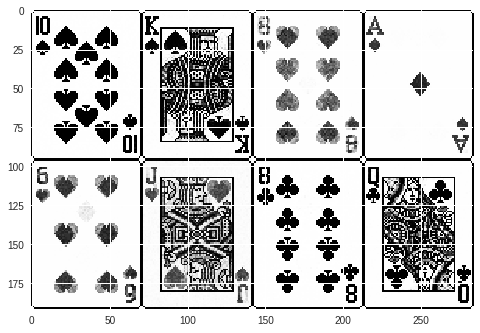

In [67]:
ResultImgShow(x_test_gen, modelName = model_name_complex, strImgLabel = "AFTER");

# 結束

In [0]:
OWNLog.SetTimeLog("DONE======")